In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import pandas as pd
import pyvista as pv
import sys
import os
sys.path.append("../../../gio")
from gio import grids
from tqdm import tqdm_notebook
from gio import filters
from logging import debug


def get_fp_fmt_grp(folder:str) -> tuple:
    """Grabs file names from given folder and returns filepaths, formation
    names and group names for specific filename exampled below. `.xml` files
    are ignored.
    
    Example:
    "tarbert A" will be read into:
        fp = folder/tarbert A
        fmt = tarbert
        grp = tarbert A
    
    Args:
        folder (str): Filepath to folder.
    
    Returns:
        tuple: Lists of [0] filepaths, [1] formations and [2] groups.
    """
    fns = [fn for fn in os.listdir(folder) if not ".xml" in fn \
           if not ".ipynb_checkpoints" in fn]  # filenames
    fps = [folder + fn for fn in fns]  # filepaths
    fmts = [fn.split()[0] for fn in fns]  # formation names
    grps = fns  # groups (used to identify fault blocks)
    return fps, fmts, grps


folder_path = "data/surfaces/"
fps, fmts, grps = get_fp_fmt_grp(folder_path)

# groups of interest
tarbert = ["tarbert A", "tarbert B", "tarbert C", "tarbert E"]
etive = ["etive A", "etive B", "etive C", "etive F", "etive D", "etive G"]
ness = ["ness A", "ness B", "ness C", "ness D", "ness G"]
faults = ["fault4", "fault3"]

surf_filter = tarbert + etive + ness + faults + ["BCU"]

#### Load surface points

In [2]:
df = pd.concat(
    [grids.read_earth_vision_grid(fp, surface=fmt, group=grp) for fp, fmt, grp in zip(fps, fmts, grps)]
)

# filter out surfaces that are not in green-list (e.g. upper cretaceous)
df = df[np.isin(df.group, surf_filter)].reset_index(drop=True)
df.formation.unique()

array(['BCU', 'ness', 'tarbert', 'fault4', 'etive', 'fault3'],
      dtype=object)

In [3]:
df.tail()

,X,Y,Z,formation,group
61064,454907.527362,6.789656e+06,-1999.533203,ness,ness C
61065,454957.527362,6.789656e+06,-1987.835083,ness,ness C
61066,455457.527362,6.789656e+06,-1954.653442,ness,ness C
61067,455507.527362,6.789656e+06,-1950.529785,ness,ness C
61068,455557.527362,6.789656e+06,-1946.100464,ness,ness C


#### Visualize loaded data

In [4]:
fmts = ['BCU', 'fault6', 'fault7', 'tarbert', 'ness', 'etive',]
colors = ['#ff3f20', '#527682', '#527682', '#443988', '#728f02', '#015482']

color_lot = {fmt:color for fmt, color in zip(fmts, colors)}
color_lot

{'BCU': '#ff3f20',
 'fault6': '#527682',
 'fault7': '#527682',
 'tarbert': '#443988',
 'ness': '#728f02',
 'etive': '#015482'}

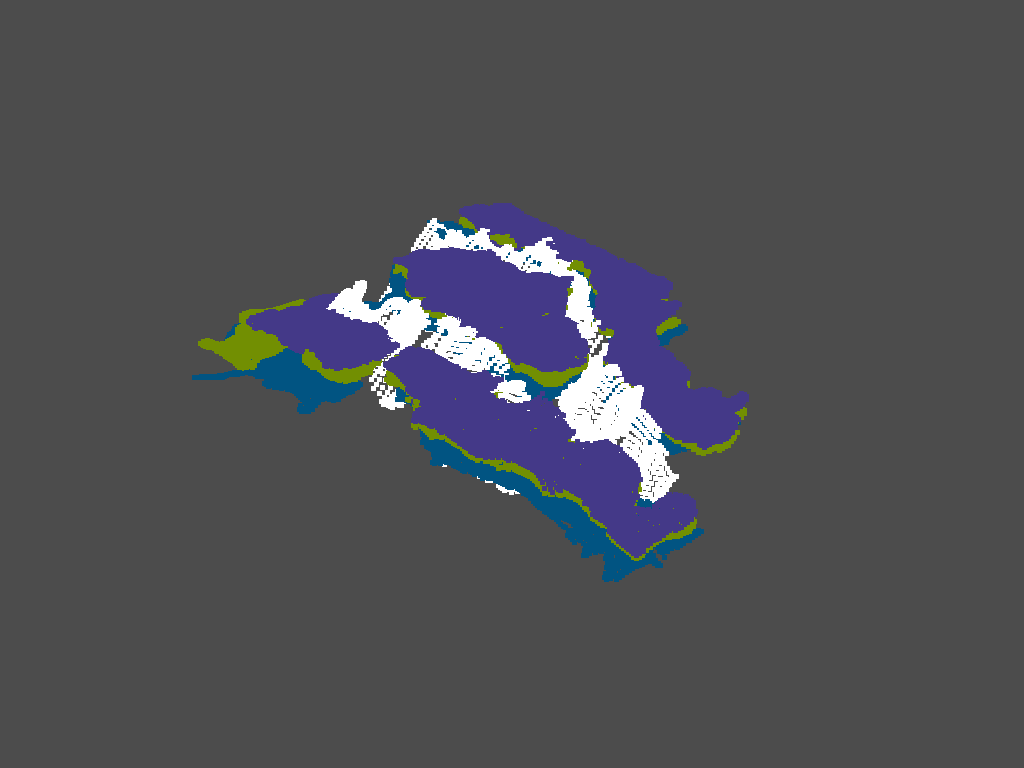

In [5]:
vertical_exaggeration = 6
formations = df.groupby("formation").groups


p = pv.Plotter(notebook=True)

for group, i in formations.items():
    if group == "BCU":
        continue
    pts = df.iloc[i][["X", "Y", "Z"]].values
    pts[:, 2] *= vertical_exaggeration
    pts[:, 1] *= 2
    pts[:, 0] *= 3
    p.add_mesh(pv.PolyData(pts), color=color_lot.get(group))

p.show();

In [6]:
extent = [451186.2, 458842.57, 6780245.33, 6789706.67, -1395.0, -2303.68]
# extent = [455000, 459000, 6785500, 6788230, -1650, -2200]
# extent = [451186.2, 458842.57, 6785500, 6788230, 1600, 2200]
extent[1] = 456500
extent[-2] = -1650
extent[-1] = -2200


# Decimation

* https://docs.pyvista.org/examples/01-filter/decimate.html

## Removing near-fault points of horizons

In [7]:
df_filtered = df

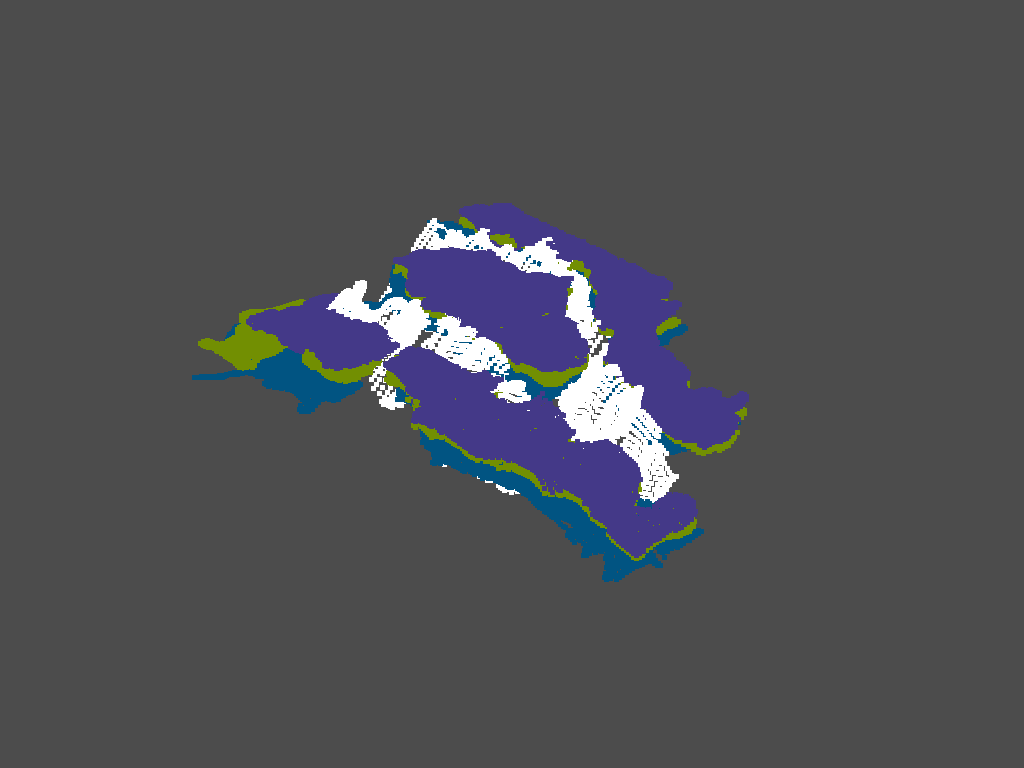

In [8]:
vertical_exaggeration = 6
formations = df_filtered.groupby("formation").groups

p = pv.Plotter(notebook=True)

for group, i in formations.items():
    if group == "BCU":
        continue
    pts = df.iloc[i][["X", "Y", "Z"]].values
    pts[:, 2] *= vertical_exaggeration
    pts[:, 1] *= 2
    pts[:, 0] *= 3
    p.add_mesh(pv.PolyData(pts), color=color_lot.get(group))

p.show();

### BCU example

## vtkQuadricDecimation

## vtkDecimatePro

## Normals

### Filter df for relevant area

remaining points: 52325
Filtering 'etive' against 'fault3' with threshold=50
Filtering 'etive' against 'fault4' with threshold=50
Filtering 'ness' against 'fault3' with threshold=50
Filtering 'ness' against 'fault4' with threshold=50
Filtering 'tarbert' against 'fault3' with threshold=50
Filtering 'tarbert' against 'fault4' with threshold=50
Filtering 'fault3' against 'BCU' with threshold=35
Filtering 'fault4' against 'BCU' with threshold=35
Filtering 'etive' against 'BCU' with threshold=35
Filtering 'ness' against 'BCU' with threshold=35
Filtering 'tarbert' against 'BCU' with threshold=35
Filtering 'etive' against 'ness' with threshold=25
Filtering 'etive' against 'tarbert' with threshold=25
Filtering 'ness' against 'etive' with threshold=25
Filtering 'ness' against 'tarbert' with threshold=25
Filtering 'tarbert' against 'ness' with threshold=25
Filtering 'tarbert' against 'etive' with threshold=25
etive F -> etive C
etive G -> etive C
ness G -> ness C
tarbert E -> tarbert C


BCU bro

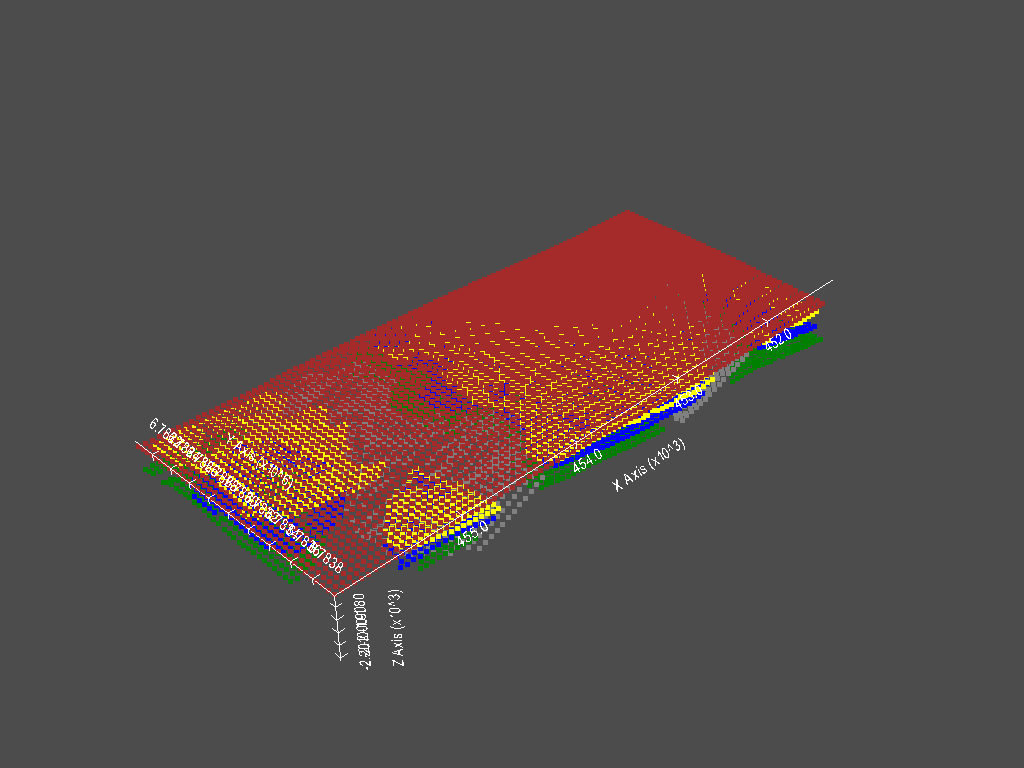

In [9]:
from importlib import reload
reload(grids)

def get_filtered_df(df, fmts1, fmts2, threshold:int):
    df_filtered = df.copy()
    i_filtered = np.array([], dtype=int)

    for fmt1 in fmts1:
        for fmt2 in fmts2:
            print(f"Filtering '{fmt1}' against '{fmt2}' with threshold={threshold}")
            i = filters.get_filtered_indices(df, fmt1, fmt2, threshold)
            i_filtered = np.append(i_filtered, i)

    i_filtered = np.unique(i_filtered)
    df_filtered = df_filtered.drop(i_filtered)
    return df_filtered

extent = [400000, 456e3, 6.7820e6, 6.7840e6, -2309, -1651]
extent_abs = np.abs(extent)

filter_x = (df.X > np.min(extent_abs[:2])) & (df.X < np.max(extent_abs[:2]))
filter_y = (df.Y > np.min(extent_abs[2:4])) & (df.Y < np.max(extent_abs[2:4]))
filter_z = (df.Z > np.min(extent_abs[4:])) & (df.Z < np.max(extent_abs[4:]))
print(f"remaining points: {np.count_nonzero(filter_x | filter_y | filter_z)}")

data = df[filter_x & filter_y]

# filter by distance from fault
fmts1 = "etive ness tarbert".split()
fmts2 = "fault3 fault4".split()
data = get_filtered_df(data, fmts1, fmts2, 50)
data = get_filtered_df(data, fmts2, ["BCU"], 35)
data = get_filtered_df(data, fmts1, ["BCU"], 35)

data = get_filtered_df(data, ["etive"], " ness tarbert".split(), 25)
data = get_filtered_df(data, ["ness"], " etive tarbert".split(), 25)
data = get_filtered_df(data, ["tarbert"], " ness etive".split(), 25)

grpmerge_LOT = {
    "etive F": "etive C", 
    "etive G": "etive C",
    "ness G": "ness C",
    "tarbert E": "tarbert C",
}

for k, v in grpmerge_LOT.items():
    print(f"{k} -> {v}")
    data.replace(k, v, inplace=True)

print("\n")
p=pv.Plotter(notebook=True)

colors = {fmt:color for fmt, color in zip("BCU etive ness tarbert fault3 fault4 ".split(), 
                                          ["brown", "green", "blue", "yellow",  "grey", "grey", ])}
pointclouds = []

for group, i in data.groupby("group").groups.items():
    pointcloud = pv.PolyData(data.loc[i][["X", "Y", "Z"]].values)
    print(group, colors[group.split()[0]])
    p.add_mesh(pointcloud, color=colors[group.split()[0]])
    pointclouds.append(pointcloud)
    
p.show_bounds()
p.show()

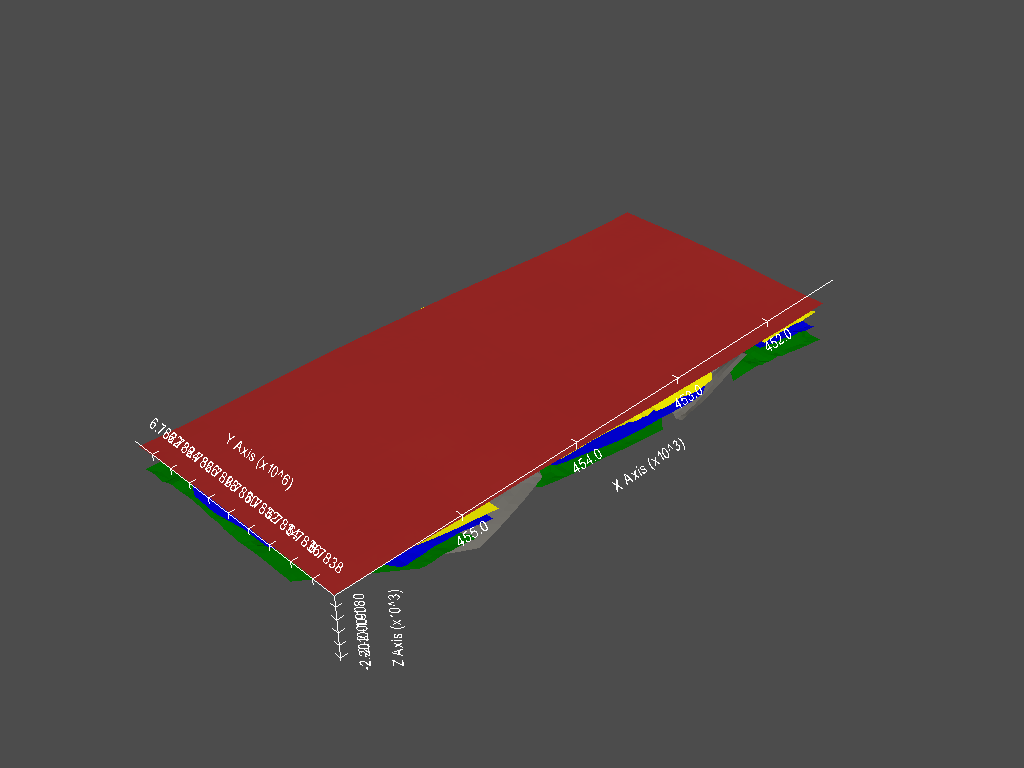

In [10]:
p=pv.Plotter(notebook=True)

trisurfs = []
for pointcloud, group in zip(pointclouds, data.groupby("group").groups.keys()):
    trisurf = pointcloud.delaunay_2d()
    trisurfs.append(trisurf)
    
    p.add_mesh(trisurf, color=colors[group.split()[0]])

p.show_bounds()
p.show()

In [11]:
smooth = 100

In [12]:
trisurfs_decimated = []
n = []
n_dec = []
data_dec = pd.DataFrame(columns=data.columns)

for trisurf, group in zip(trisurfs, data.groupby("group").groups.keys()):
    
    
    if group == "BCU":
        k = 75 # 200
    elif "B" in group:
        k = 50 # 125
    elif "fault" in group:
        k = 50 # 100
    else:
        k = 25 # 75
    
    n_points = trisurf.points.shape[0]
    n.append(n_points)
        
    factor = 1 - 1 / (n_points / k)
    
    
#     trisurf_dec = trisurf.decimate_pro(factor)
    trisurf_dec = trisurf.decimate(factor)
    if smooth:
        trisurf_dec = trisurf_dec.smooth(n_iter=smooth)
    n_points_dec = trisurf_dec.points.shape[0]
    n_dec.append(n_points_dec)
    trisurfs_decimated.append(trisurf_dec)
    
    data_dec = data_dec.append(
        pd.DataFrame({
            "X": trisurf_dec.points[:,0],
            "Y": trisurf_dec.points[:,1],
            "Z": trisurf_dec.points[:,2],
            "formation": group.split()[0],
            "group": group
        })
    )
    
    print(f"{group}, n={n_points} -> {n_points_dec}, decimation factor: {factor:.02f}")

data_dec.reset_index(inplace=True, drop=True)
print(f"\nDecimated from {np.sum(n)} to {np.sum(n_dec)} points.")

BCU, n=3800 -> 88, decimation factor: 0.98
etive A, n=635 -> 31, decimation factor: 0.96
etive B, n=1291 -> 58, decimation factor: 0.96
etive C, n=382 -> 31, decimation factor: 0.93
fault3, n=742 -> 56, decimation factor: 0.93
fault4, n=773 -> 59, decimation factor: 0.94
ness A, n=401 -> 32, decimation factor: 0.94
ness B, n=1424 -> 57, decimation factor: 0.96
ness C, n=451 -> 30, decimation factor: 0.94
tarbert A, n=354 -> 30, decimation factor: 0.93
tarbert B, n=1389 -> 58, decimation factor: 0.96
tarbert C, n=614 -> 30, decimation factor: 0.96

Decimated from 12256 to 560 points.


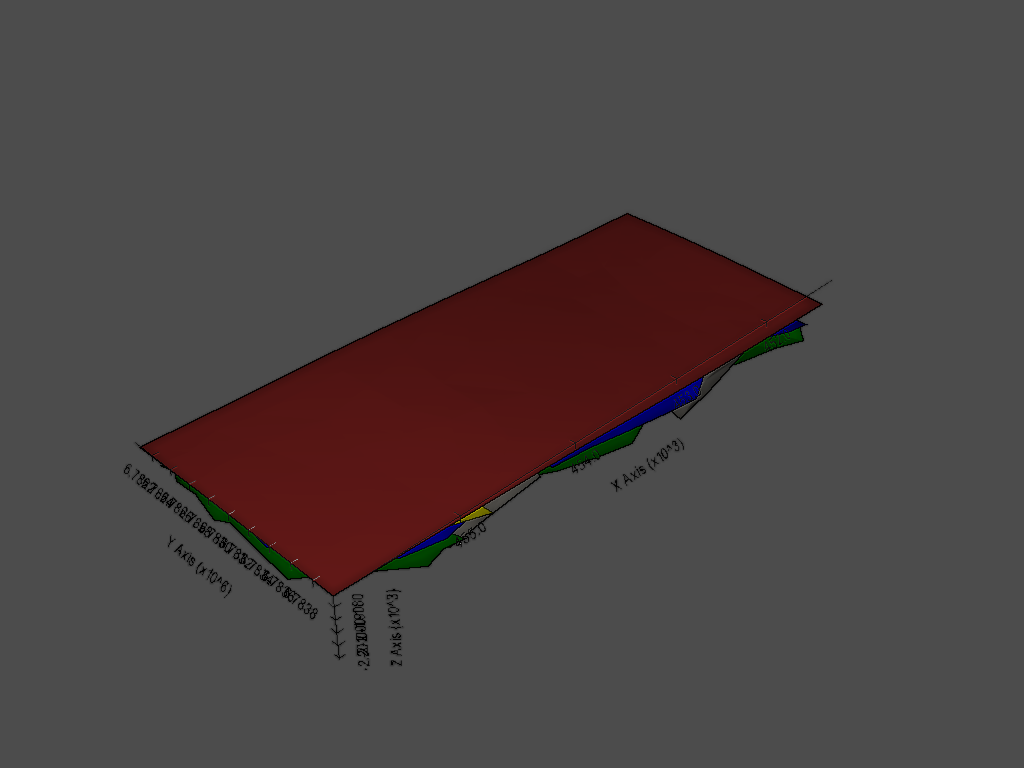

In [13]:
p = pv.Plotter(notebook=True)
for trisurf, group in zip(trisurfs_decimated, data.groupby("group").groups.keys()):
    p.add_mesh(trisurf, color=colors[group.split()[0]])
p.enable_eye_dome_lighting()
p.show_bounds()
p.show()

In [14]:
ve = 3

In [16]:
from tqdm.notebook import tqdm

In [17]:
for i, group in tqdm(enumerate(np.unique(data_dec.group))):
    fmt = group.split()[0]
    data = data_dec[data_dec.group==group][["X", "Y", "Z"]].values
    data[:, 2] *= ve
    
    if data.shape[0] == 0:
        continue
        
    surfpts, orients = grids.get_gempy_data_from_surfpoints(data, formation=fmt, group=group, polarity=1)
    print(f"{group}: {surfpts.shape}")
    
    if i == 0:
        surface_points = surfpts.copy()
        orientations = orients.copy()
    else:
        surface_points = surface_points.append(surfpts)
        orientations = orientations.append(orients)
        
orientations.reset_index(inplace=True, drop=True)
surface_points.reset_index(inplace=True, drop=True)

BCU: (88, 5)
etive A: (31, 5)
etive B: (58, 5)
etive C: (31, 5)
fault3: (56, 5)
fault4: (59, 5)
ness A: (32, 5)
ness B: (57, 5)
ness C: (30, 5)
tarbert A: (30, 5)
tarbert B: (58, 5)
tarbert C: (30, 5)



#### Removing final points that are too close to the faults (due to some artifact points from Delaunay)

In [18]:
fmts1 = "etive ness tarbert".split()
fmts2 = "fault3 fault4".split()
surface_points = get_filtered_df(surface_points, fmts1, fmts2, 100) # 250)  # 350

Filtering 'etive' against 'fault3' with threshold=100
Filtering 'etive' against 'fault4' with threshold=100
Filtering 'ness' against 'fault3' with threshold=100
Filtering 'ness' against 'fault4' with threshold=100
Filtering 'tarbert' against 'fault3' with threshold=100
Filtering 'tarbert' against 'fault4' with threshold=100


In [19]:
surface_points.to_csv("data/gullfaks_topology_surface_points_dec.csv", index=False)
orientations.G_x *= -1
orientations.G_y *= -1
orientations.G_z *= -1
orientations[::3].to_csv("data/gullfaks_topology_orientations_dec.csv", index=False)

In [ ]:
ve = 1
extent = [451e3, 456e3, 6.7820e6, 6.7840e6, -2309 * ve, -1651 * ve]

geo_model = gp.create_model('Topology-Gullfaks')

gp.init_data(geo_model, extent, [75,50,125], 
      path_o = "data/gullfaks_topology_orientations_dec.csv",
      path_i = "data/gullfaks_topology_surface_points_dec.csv", default_values=True)

series_distribution = {
    "fault3": "fault3",
    "fault4": "fault4",
    "unconformity": "BCU",
    "sediments": ("tarbert", "ness", "etive"),
}

gp.map_series_to_surfaces(geo_model, 
                          series_distribution, 
                          remove_unused_series=True)

geo_model.set_is_fault(["fault3"])
geo_model.set_is_fault(["fault4"])

geo_model.reorder_series(["fault3", "fault4", "unconformity", 
                          "sediments", "Basement"])

rel_matrix = np.array([
                       [0,0,0,1,1],
                       [0,0,0,1,1],
                       [0,0,0,0,0],
                       [0,0,0,0,0],
                       [0,0,0,0,0]])

geo_model.set_fault_relation(rel_matrix)

surf_groups = pd.read_csv("gullfaks_topology_surface_points_dec.csv").group
geo_model.surface_points.df["group"] = surf_groups
orient_groups = pd.read_csv("gullfaks_topology_orientations_dec.csv").group
geo_model.orientations.df["group"] = orient_groups

geo_model.surface_points.df.reset_index(inplace=True, drop=True)
geo_model.orientations.df.reset_index(inplace=True, drop=True)

In [ ]:
tarbert = [6, 17, 58, 82]
ness = [87, 70, 68, 83, 79, 23, 76, 19, 59, 12]
etive = [56, 70, 3, 4, 22, 15, 11, 28, 21, 30, 36]

ness_i = geo_model.surface_points.df[geo_model.surface_points.df.surface=="ness"].iloc[ness].index
etive_i = geo_model.surface_points.df[geo_model.surface_points.df.surface=="etive"].iloc[etive].index
tarbert_i = geo_model.surface_points.df[geo_model.surface_points.df.surface=="tarbert"].iloc[tarbert].index
remove = np.unique(np.concatenate((ness_i, 
                                   etive_i, 
                                   tarbert_i), axis=0))
geo_model.delete_surface_points(remove);

geo_model.surface_points.df.reset_index(inplace=True, drop=True)

tarbert = [5, 11, 14]
etive = [7, 38, 65]
etive_i = geo_model.surface_points.df[geo_model.surface_points.df.surface=="etive"].iloc[etive].index
tarbert_i = geo_model.surface_points.df[geo_model.surface_points.df.surface=="tarbert"].iloc[tarbert].index

remove = np.unique(np.concatenate((etive_i, 
                                   tarbert_i), axis=0))
geo_model.delete_surface_points(remove);

geo_model.surface_points.df.reset_index(inplace=True, drop=True)

ness = [46,62,63]
tarbert = [84, 82, 83, 23, 1]
ness_i = geo_model.surface_points.df[geo_model.surface_points.df.surface=="ness"].iloc[ness].index
tarbert_i = geo_model.surface_points.df[geo_model.surface_points.df.surface=="tarbert"].iloc[tarbert].index

remove = np.unique(np.concatenate((ness_i, 
                                  tarbert_i), axis=0))
geo_model.delete_surface_points(remove);
geo_model.surface_points.df.reset_index(inplace=True, drop=True)

tarbert = [15, 16, 11]
ness = [6, 63, 53, 54]
ness_i = geo_model.surface_points.df[geo_model.surface_points.df.surface=="ness"].iloc[ness].index
tarbert_i = geo_model.surface_points.df[geo_model.surface_points.df.surface=="tarbert"].iloc[tarbert].index
remove = np.unique(np.concatenate((ness_i, 
                                   tarbert_i), axis=0))
geo_model.delete_surface_points(remove);
geo_model.surface_points.df.reset_index(inplace=True, drop=True)

In [ ]:
geo_model.surface_points.df.to_csv("data/filtered_surface_points.csv", index=False)
geo_model.orientations.df.to_csv("data/filtered_orientations.csv", index=False)